In [3]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#librerias
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from PIL import Image
import torch
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models #just for debugging
from torchvision import transforms
from torchsummary import summary #just for debugging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix



In [ ]:
#cleaning up
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes')

In [ ]:
#Just run once, and set the selected dir
os.mkdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes')

In [ ]:
#Just run once, and set the selected dir
!unzip "/content/drive/MyDrive/PROYECTO FINAL DL/classes.zip" -d "/content/drive/MyDrive/PROYECTO FINAL DL/classes"

In [6]:
#getting metadata from the CSV file (main purpose is get labels and its indexes)
data_skin = pd.read_csv('/content/drive/MyDrive/PROYECTO FINAL DL/DATASET_UNZIPPED/HAM10000_metadata.csv')

In [ ]:
#We leave aside other labels but these:
# nv - (melanocytic nevy)
# mel - (melanoma)
# bkl - (benign keratosis)
# labeled as 5, 4 & 2  

shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/bcc')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/akiec')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/df')
shutil.rmtree('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/vasc')

In [ ]:
len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel'))

1099

In [ ]:
#we are gonna use 1099 images o the 3 most significant types, so we erase the others
import glob
removing_files = glob.glob('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel/*')
print(len(removing_files))

x=len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel'))
le=x
for i in removing_files:
    if (le == 1099):
      break
    else:
      os.remove(i) 
    le=le-1

removing_files = glob.glob('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv/*')

x=len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv'))
le=x
for i in removing_files:
    if (le == 1099):
      break
    else:
      os.remove(i) 
    le=le-1

1099


In [ ]:
#we can confirm that theres only 1099 on each folder
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/bkl')))
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/mel')))
print(len(os.listdir('/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes/nv')))

1099
1099
1099


In [16]:
#Loading dataset with imagefolder technique
train_dir='/content/drive/MyDrive/PROYECTO FINAL DL/classes/classes' #getting image directory

TRANSFORM_IMG=transforms.Compose([
	transforms.Resize(size=(64,64)), #sizing all images to 64x64
	transforms.ToTensor()]) 
	#transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

#making a dataset object for the imagefolder
skin_dataset = torchvision.datasets.ImageFolder(root=train_dir,transform=TRANSFORM_IMG) 

#splitting dataset into train and test
train = int(len(skin_dataset) * 0.8)
test = len(skin_dataset) - train

train_dataset, test_dataset = torch.utils.data.random_split(skin_dataset, [train, test])

train_dataLoader = DataLoader(train_dataset, shuffle=True, sampler=None, batch_size=32) #Getting data for training
test_dataLoader = DataLoader(test_dataset, shuffle=True, sampler=None, batch_size=32) #Getting data for testing



labels=np.array(skin_dataset.targets)
(unique,counts)=np.unique(labels,return_counts=True)
frecuencies_of_labels=np.asarray((unique, counts))

print(frecuencies_of_labels) #visualizing the amount of labels with its amount of images data
print(len(train_dataset))
print(len(test_dataset))

[[   0    1    2]
 [1099 1099 1099]]
2637
660


In [7]:
classes=train_dataLoader.dataset.dataset.classes
print(classes)
#dir(train_dataLoader.dataset.dataset.classes)

['bkl', 'mel', 'nv']


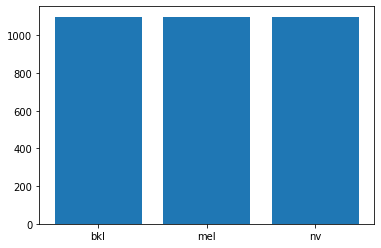

In [ ]:
#frecuencies of datas against its labels
plt.bar(frecuencies_of_labels[0,:], frecuencies_of_labels[1,:])
plt.xticks(frecuencies_of_labels[0,:],classes);

In [ ]:
data_skin['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

Feature batch shape: torch.Size([64, 64, 3, 32])
Labels batch shape: torch.Size([32])
torch.Size([3, 64, 64])


<ipython-input-8-3d701c240185>:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  print(f"Feature batch shape: {train_features.T.size()}")


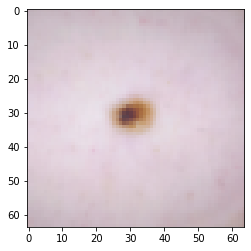

Label: bkl
Feature batch shape: torch.Size([64, 64, 3, 32])
Labels batch shape: torch.Size([32])
torch.Size([3, 64, 64])


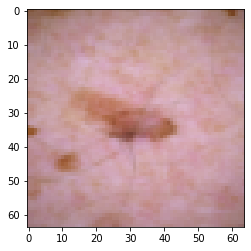

Label: mel
Feature batch shape: torch.Size([64, 64, 3, 32])
Labels batch shape: torch.Size([32])
torch.Size([3, 64, 64])


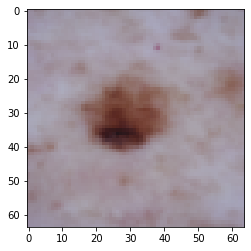

Label: nv
Feature batch shape: torch.Size([64, 64, 3, 32])
Labels batch shape: torch.Size([32])
torch.Size([3, 64, 64])


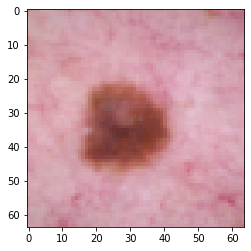

Label: nv


In [8]:
labels_map = {
    0: "bkl",
    1: "mel",
    2: "nv",
}

# Display image and label.
train_features, train_labels = next(iter(test_dataLoader))
for i in range(4):
  print(f"Feature batch shape: {train_features.T.size()}")
  print(f"Labels batch shape: {train_labels.size()}")
  img = train_features[i].squeeze()
  label = train_labels[i]
  print(img.shape)
  plt.imshow(img.T)
  plt.show()
  print(f"Label: {labels_map[torch.IntTensor.item(label)]}")

tensor([[[0.7765, 0.7804, 0.8078,  ..., 0.6824, 0.6784, 0.6667],
         [0.7804, 0.7922, 0.8078,  ..., 0.6824, 0.6745, 0.6627],
         [0.7843, 0.8000, 0.8078,  ..., 0.6863, 0.6824, 0.6745],
         ...,
         [0.7451, 0.7412, 0.7451,  ..., 0.6471, 0.6471, 0.6510],
         [0.7333, 0.7412, 0.7529,  ..., 0.6471, 0.6471, 0.6431],
         [0.7294, 0.7373, 0.7451,  ..., 0.6549, 0.6431, 0.6275]],

        [[0.6549, 0.6667, 0.7098,  ..., 0.5451, 0.5333, 0.5216],
         [0.6588, 0.6863, 0.7098,  ..., 0.5490, 0.5333, 0.5176],
         [0.6627, 0.6863, 0.7020,  ..., 0.5569, 0.5412, 0.5333],
         ...,
         [0.6000, 0.5882, 0.6000,  ..., 0.4863, 0.5059, 0.5255],
         [0.5843, 0.5961, 0.6157,  ..., 0.4902, 0.5137, 0.5216],
         [0.5725, 0.5922, 0.6078,  ..., 0.5176, 0.5137, 0.4941]],

        [[0.6549, 0.6745, 0.7255,  ..., 0.4902, 0.4784, 0.4706],
         [0.6510, 0.6863, 0.7137,  ..., 0.5020, 0.4784, 0.4627],
         [0.6549, 0.6824, 0.6980,  ..., 0.5098, 0.4902, 0.

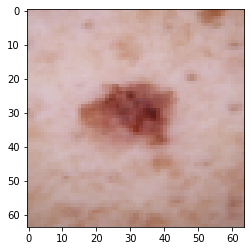

tensor([[[198, 199, 206,  ..., 174, 173, 170],
         [199, 202, 206,  ..., 174, 172, 169],
         [200, 204, 206,  ..., 175, 174, 172],
         ...,
         [190, 189, 190,  ..., 165, 165, 166],
         [187, 189, 192,  ..., 165, 165, 164],
         [186, 188, 190,  ..., 167, 164, 160]],

        [[167, 170, 181,  ..., 139, 136, 133],
         [168, 175, 181,  ..., 140, 136, 132],
         [169, 175, 179,  ..., 142, 138, 136],
         ...,
         [153, 150, 153,  ..., 124, 129, 134],
         [149, 152, 157,  ..., 125, 131, 133],
         [146, 151, 155,  ..., 132, 131, 126]],

        [[167, 172, 185,  ..., 125, 122, 120],
         [166, 175, 182,  ..., 128, 122, 118],
         [167, 174, 178,  ..., 130, 125, 125],
         ...,
         [142, 138, 141,  ..., 114, 120, 129],
         [135, 139, 146,  ..., 114, 122, 127],
         [131, 138, 144,  ..., 123, 123, 117]]], dtype=torch.int32)
tensor(220, dtype=torch.int32)


<function matplotlib.pyplot.show(*args, **kw)>

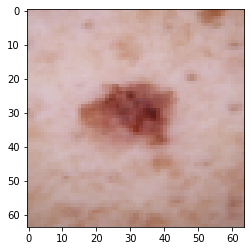

In [ ]:
#Before continuo we must check datatype and form of our tensors
#We need to normalize them in 0 to 1 range (in 255 RGB scale)
#visualizating an image
tra=train_features[15,:,:,:] #we get a sample
print(tra) #we print the sample for checking the values range
#we can see that aparrently they are in range between 0 and 1 (which)
#we can confirm that by getting the max value
print(torch.max(tra)) #we confirm that is acctually lower or equal than 1

#we plot the sample for confirm visually that colors and contrast is normal (only good equeality normalizations
#keep the original proportions)
plt.imshow(tra.T)
plt.show()

#and for last we can finlly confirm once and for all that it is already normalized by inverting it 
#multipliying by 255 and casting to int
tra=tra*255
tra = tra.int()
print(tra)
print(torch.max(tra))
plt.imshow(tra.T)
plt.show
#so we now that it is actually normalize and can continue

In [ ]:
#figuring out the number of neurons of the first fully conected layer
#This is a pre-model
conv1=torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)

conv2=torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)

conv3=torch.nn.Conv2d(in_channels = 16, out_channels = 26, kernel_size = 5)

pool=nn.MaxPool2d(kernel_size=2, stride=2)



print(train_features.shape)


x=conv1(train_features)
print(x.shape)
x=pool(x)
print(x.shape)
x=conv2(x)
print(x.shape)
x=pool(x)
print(x.shape)
x=conv3(x)
print(x.shape)
x=pool(x)
print(x.shape)




torch.Size([32, 3, 64, 64])
torch.Size([32, 6, 60, 60])
torch.Size([32, 6, 30, 30])
torch.Size([32, 16, 26, 26])
torch.Size([32, 16, 13, 13])
torch.Size([32, 26, 9, 9])
torch.Size([32, 26, 4, 4])


In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 5)
        self.conv2 = nn.Conv2d(256, 128, 5)
        self.conv3 = nn.Conv2d(128, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 3)

        # Define proportion of neurons to dropout
        self.dropout = nn.Dropout(0.3)
        # Define softmax 
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        #x = self.softmax(x)
        x = self.fc2(x)
        return x


net = Net()

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
count=0
model_backup=[]
loss_list=[]
iteration_list=[]
accuracy_list=[]
for epoch in range(100):  # loop over the dataset multiple times
    net.train(True)
    running_loss = 0.0
    total=0
    correct=0
    for i, data in enumerate(train_dataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
        running_loss += loss.item()
    count+=1
    # save statistics
    loss_list.append(running_loss)
    iteration_list.append(count)
    accuracy_list.append(float(correct / total))
    #save model
    PATH = 'skin_cancer_net_Epoch'+str(epoch)
    model_backup.append(torch.save(net.state_dict(), PATH))
    print(f'Epoch: [{epoch + 1}, {i}] Loss: {running_loss/len(train_dataLoader) }   Accuracy: {correct / float(total)}')


print('Finished Training')

#save model
PATH = 'skin_cancer_net'
torch.save(net.state_dict(), PATH)

#TOOK 25133.28 seconds num of workers default
#took 4 min 8 seconds num of workers 2
#took 5 min 8 seconds num of workers default

Epoch: [1, 82] Loss: 1.0392870658851532   Accuracy: 0.45278725028038025


KeyboardInterrupt: ignored

In [ ]:
Epoch: [1, 82] Loss: 1.099314906510962   Accuracy: 0.3265073895454407
Epoch: [2, 82] Loss: 1.098790965884565   Accuracy: 0.3386423885822296
Epoch: [3, 82] Loss: 1.0986824251083007   Accuracy: 0.32878270745277405
Epoch: [4, 82] Loss: 1.0987128651285747   Accuracy: 0.3386423885822296
30 min

In [ ]:
#save info lists
pat='/content/drive/MyDrive/PROYECTO FINAL DL/'
df=pd.DataFrame(loss_list)
df.to_csv(pat+'Loss_List_GPU_SKIN_CANCER_MODEL')

df=pd.DataFrame(iteration_list)
df.to_csv(pat+'Iter_List_GPU_SKIN_CANCER_MODEL')

df=pd.DataFrame(accuracy_list)
df.to_csv(pat+'accuracy_List_GPU_SKIN_CANCER_MODEL')


In [ ]:
#save model to drive
PATH='/content/drive/MyDrive/PROYECTO FINAL DL/MODEL_GPU_TORCH_SKINCANCER'
torch.save({'Skin_Cancer_Model_GPU_TORCH': net.state_dict(), 
            'Skin_Cancer_Optimizer_GPU_TORCH': optimizer.state_dict()}, PATH)

In [ ]:
#Load the model
test_net=Net() #inherit class 
test_opt=optim.Adam(test_net.parameters(), lr=0.001) #getting same optimizer class

checkpoint= torch.load('/content/drive/MyDrive/PROYECTO FINAL DL/MODEL_GPU_TORCH_SKINCANCER')

test_net.load_state_dict(checkpoint['Skin_Cancer_Model_GPU_TORCH'])
test_opt.load_state_dict(checkpoint['Skin_Cancer_Optimizer_GPU_TORCH'])

Real:       mel   mel   bkl   bkl   nv    mel   mel   nv    nv    nv    nv    mel   bkl   mel   nv    mel   mel   bkl   nv    nv    mel   nv    mel   nv    mel   bkl   nv    nv    bkl   bkl   mel   nv   
Predicted:  bkl   bkl   bkl   nv    nv    nv    bkl   nv    bkl   nv    nv    mel   bkl   bkl   bkl   bkl   bkl   bkl   nv    nv    nv    bkl   bkl   nv    nv    bkl   nv    mel   bkl   nv    bkl   nv   


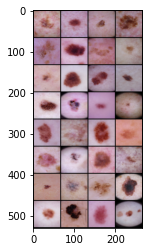

In [ ]:
#predicted labels against real labels (16 samples)
dataiter = iter(test_dataLoader)
images, labels = next(dataiter)
# print images
plt.imshow(torchvision.utils.make_grid(images).T)
print('Real:      ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

#model
net.train()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels))))

In [ ]:
#making an evaluation of the model
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_net.eval()
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = test_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

#record 58.3% lr 0.001, 3 fcl 120, 84, 3, imagenes de 64,64 y batch de 32
#record 61.21% lr 0.001, 3 fcl 120, 84, 3, imagenes de 128,128 y batch de 32

Accuracy of the network on the test images: 66.96969696969697 %


In [ ]:
#checking class prediction performance
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: bkl   is 80.1 %
Accuracy for class: mel   is 41.0 %
Accuracy for class: nv    is 81.3 %


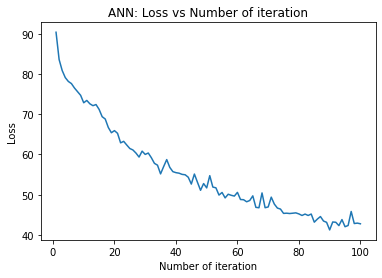

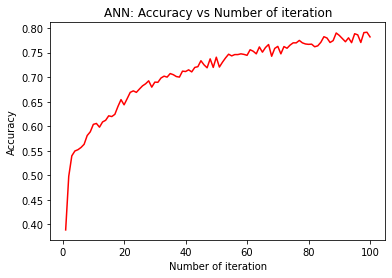

In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
#figuring out the number of neurons of the first fully conected layer
#This is a pre-model
conv1=torch.nn.Conv2d(in_channels = 3, out_channels = 256, kernel_size = 5)

conv2=torch.nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 5)

conv3=torch.nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 5)

pool=nn.MaxPool2d(kernel_size=2, stride=2)



print(train_features.shape)
#visualizating an image
#plt.imshow(train_features[15,:,:,:].T)
#plt.show()


x=conv1(train_features)
print(x.shape)

x=pool(x)
print(x.shape)

x=conv2(x)
print(x.shape)

x=pool(x)
print(x.shape)

x=conv3(x)
print(x.shape)

x=pool(x)
print(x.shape)



#we can see that the correct number of neurons as the output channels x height x width

torch.Size([16, 3, 64, 64])
torch.Size([16, 256, 60, 60])
torch.Size([16, 256, 30, 30])
torch.Size([16, 128, 26, 26])
torch.Size([16, 128, 13, 13])
torch.Size([16, 64, 9, 9])
torch.Size([16, 64, 4, 4])


In [ ]:
#confirm we are now on GPU mode
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from torch.nn.modules.activation import Softmax
#Second model (bigger and with dropouts)
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 5)
        self.conv2 = nn.Conv2d(256, 128, 5)
        self.conv3 = nn.Conv2d(128, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 3)

        # Define proportion of neurons to dropout
        self.dropout = nn.Dropout(0.3)
        # Define softmax 
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        #x = self.softmax(x) #compatibility issues
        x = self.fc2(x)
        return x


net2 = Net2()
net2.cuda()

Net2(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=1)
)

In [ ]:
#creating hyper parameters
learning_rate = 0.001
num_epochs = 100

error2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)

In [ ]:
#change to GPU
device = torch.device('cpu')

In [ ]:
count=0
model_backup2=[]
loss_list2=[]
iteration_list2=[]
accuracy_list2=[]
for epoch in range(100):  # loop over the dataset multiple times
    net2.train(True)
    running_loss = 0.0
    total=0
    correct=0
    for i, (inputs, labels) in enumerate(train_dataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs=inputs.cuda()
        labels=labels.cuda()
        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = error2(outputs, labels)
        loss.backward()
        optimizer2.step()



        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
        running_loss += loss.item()
    count+=1
    # save statistics
    loss_list2.append(running_loss)
    iteration_list2.append(count)
    accuracy_list2.append(float(correct / total))
    #save model
    PATH = 'skin_cancer_net2_Epoch'+str(epoch)
    model_backup2.append(torch.save(net2.state_dict(), PATH))
    print(f'Epoch: [{epoch + 1}, {i}] Loss: {running_loss/len(train_dataLoader) }   Accuracy: {correct / float(total)}')


print('Finished GPU Training')

#took 2460.5 seconds for training

In [ ]:
#save info lists
pat='/content/drive/MyDrive/PROYECTO FINAL DL/'
df=pd.DataFrame(loss_list2)
df.to_csv(pat+'Loss_List_GPU_SKIN_CANCER_MODEL2')

df=pd.DataFrame(iteration_list2)
df.to_csv(pat+'Iter_List_GPU_SKIN_CANCER_MODEL2')

df=pd.DataFrame(accuracy_list2)
df.to_csv(pat+'accuracy_List_GPU_SKIN_CANCER_MODEL2')


#save model to drive
PATH='/content/drive/MyDrive/PROYECTO FINAL DL/MODEL_GPU_TORCH_SKINCANCER2'
torch.save({'Skin_Cancer_Model_GPU_TORCH2': net2.state_dict(), 
            'Skin_Cancer_Optimizer_GPU_TORCH2': optimizer2.state_dict()}, PATH)


#Load the model
test_net2=Net2() #inherit class 
test_opt2=optim.Adam(test_net2.parameters(), lr=0.001) #getting same optimizer class

checkpoint2= torch.load('/content/drive/MyDrive/PROYECTO FINAL DL/MODEL_GPU_TORCH_SKINCANCER2')

test_net2.load_state_dict(checkpoint2['Skin_Cancer_Model_GPU_TORCH2'])
test_opt2.load_state_dict(checkpoint2['Skin_Cancer_Optimizer_GPU_TORCH2'])

test_net2.cuda()

Net2(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=1)
)

Real:       mel   bkl   bkl   nv    mel   mel   mel   mel   mel   mel   mel   bkl   mel   nv    mel   bkl   bkl   nv    bkl   bkl   bkl   nv    bkl   mel   bkl   mel   bkl   mel   bkl   mel   bkl   bkl  
Predicted:  bkl   bkl   bkl   nv    mel   mel   bkl   mel   bkl   mel   mel   bkl   mel   nv    nv    bkl   bkl   nv    bkl   bkl   bkl   nv    bkl   mel   bkl   bkl   bkl   mel   bkl   mel   bkl   bkl  


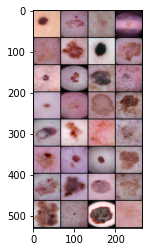

In [ ]:
#predicted labels against real labels (16 samples)
dataiter = iter(test_dataLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images).T)
print('Real:      ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))
images=images.cuda()
labels=labels.cuda()
#model
test_net2.eval()
outputs = test_net2(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels))))

In [ ]:
#making an evaluation of the model
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_net2.eval();
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()

        # calculate outputs by running images through the network
        outputs = test_net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 66.66666666666667 %


In [ ]:
#checking class prediction performance
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataLoader:
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        outputs = test_net2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: bkl   is 81.7 %
Accuracy for class: mel   is 62.4 %
Accuracy for class: nv    is 55.9 %


In [21]:
import csv

accuracy_list2= open('/content/drive/MyDrive/PROYECTO FINAL DL/accuracy_test_gpu2.txt').read().splitlines()

In [27]:
iteration_list2=[]
for i in range(len(accuracy_list2)):
  accuracy_list2[i] = float(accuracy_list2[i])
  iteration_list2.append(i)

In [26]:
print(accuracy_list2)

[0.405005693, 0.477436483, 0.533181667, 0.549867272, 0.559726954, 0.580204785, 0.586272299, 0.577171028, 0.604474783, 0.618505895, 0.603716314, 0.621539652, 0.639362931, 0.641259015, 0.641638219, 0.627227902, 0.642017424, 0.64656806, 0.6514979, 0.662116051, 0.678043246, 0.670079648, 0.676905572, 0.683731496, 0.668941975, 0.68486917, 0.686386049, 0.692832768, 0.687523723, 0.678043246, 0.705726206, 0.703071654, 0.70762229, 0.698141813, 0.706484616, 0.70193404, 0.709518373, 0.717481971, 0.702313244, 0.716723561, 0.717102766, 0.72317028, 0.724307895, 0.725445569, 0.727341652, 0.737201333, 0.745164931, 0.737201333, 0.737959802, 0.736442924, 0.747061074, 0.753128529, 0.747440279, 0.741751969, 0.758816838, 0.759575248, 0.761092126, 0.748577952, 0.760712922, 0.762609005, 0.760712922, 0.765642762, 0.767159641, 0.76791811, 0.757679164, 0.7622298, 0.771331072, 0.761850595, 0.788395882, 0.762609005, 0.781190753, 0.764125884, 0.768297315, 0.766021967, 0.782328427, 0.778536201, 0.76791811, 0.8016685

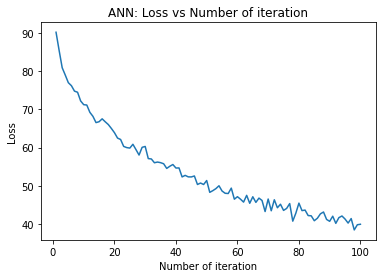

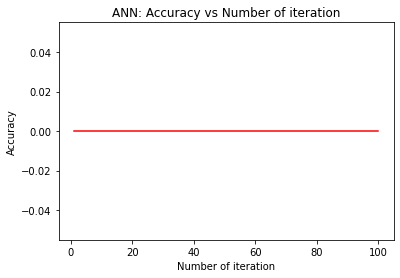

In [ ]:
# visualization loss 
plt.plot(iteration_list2,loss_list2)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list2,accuracy_list2,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

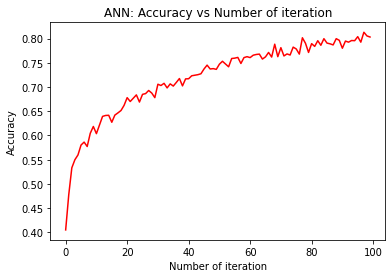

In [28]:
# visualization accuracy 
plt.plot(iteration_list2,accuracy_list2,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()